## Predicting Bitcoin Prices 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

The bitcoin prices dataset has six attributes. ARIMA is one of the classical statistical methods for time-series forecasting. It works for univariate forecasting. It only requires a time sequence and one attribute to predict. I am going to work on closing price.

In [2]:
# column titles
c_titles = ["time", "low", "high", "open", "close", "volume"] 
# read_csv. use date as index
bitcoin = pd.read_csv("crypto_data/BTC-USD.csv", index_col=0, names=c_titles)
# convert index from unix-time stamp to pandas datetime, unit is seconds
bitcoin.index = pd.to_datetime(bitcoin.index, unit='s')
# select closing price
bitcoin = bitcoin[['close']]

In [3]:
bitcoin.head()

,close
time,
2018-06-14 09:31:00,6489.549805
2018-06-14 09:32:00,6487.379883
2018-06-14 09:33:00,6479.410156
2018-06-14 09:34:00,6479.410156
2018-06-14 09:35:00,6479.979980


### Preprocessing

In time-series forcasting, data should be sequential. Interval shall not contain missing timestamps. 

In [4]:
# included months
np.unique(bitcoin.index.month)

array([6, 7, 8], dtype=int64)

In [5]:
# included hours
np.unique(bitcoin.index.hour)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [6]:
# included minutes
np.unique(bitcoin.index.minute)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

In [7]:
# included seconds
np.unique(bitcoin.index.second)

array([0], dtype=int64)

There are 3 months, 24 hours and 60 minutes. 

### Missing Days

In [8]:
import calendar
for month_idx in [6, 7, 8]:
    # get earliest day for a month
    minimum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.min().strftime('%d'))
    # get latest day for a month
    maximum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.max().strftime('%d'))
    print(f"earliest day for {calendar.month_abbr[month_idx]} is {minimum_day}")
    print(f"latest day for {calendar.month_abbr[month_idx]} is {maximum_day}")
    print()
    print("days")
    print(np.unique(bitcoin.loc[f"2018-{month_idx}"].index.day))
    print()
    

earliest day for Jun is 14
latest day for Jun is 30

days
[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]

earliest day for Jul is 1
latest day for Jul is 31

days
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

earliest day for Aug is 1
latest day for Aug is 25

days
[ 1  2  3  4  5  6 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]



The whole series starts from June 14. August contains missing days

### Missing Hours

In [9]:
hours_list = []
for month_idx in [6, 7, 8]:
    # get earliest day for a month
    minimum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.min().strftime('%d'))
    # get latest day for a month
    maximum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.max().strftime('%d'))
    
    for day in range(minimum_day, maximum_day + 1):
        hours = np.unique(bitcoin.loc[f"2018-{month_idx}-{day}"].index.hour)
        # if missing hours print that hour
        if len(np.intersect1d(hours, range(0,24))) != 24:
            print()
            print(f"month: {calendar.month_abbr[month_idx]}, day:{day}")
            print(hours)
            print()


month: Jun, day:14
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


month: Aug, day:1
[ 0  1  2  3  4  5  6 21 22 23]


month: Aug, day:7
[]


month: Aug, day:8
[]


month: Aug, day:9
[]


month: Aug, day:10
[16 17 18 19 20 21 22 23]


month: Aug, day:25
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]



The missing hours in June 14 and August 25 don't affect the data because they are the starting and ending sequences

### Missing Minutes

In [10]:
minutes_list = []
for month_idx in [6, 7, 8]:
    # get earliest day for a month
    minimum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.min().strftime('%d'))
    # get latest day for a month
    maximum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.max().strftime('%d'))
    #print(f"number of days in {calendar.month_abbr[month_idx]}: {maximum_day - minimum_day + 1}")
    for day in range(minimum_day, maximum_day + 1):
        #handle the three missing days in august
        if(month_idx == 8 and day in [7,8,9]):
            continue
        minimum_hour = int(bitcoin.loc[f"2018-{month_idx}-{day}"].index.min().strftime('%H'))
        maximum_hour = int(bitcoin.loc[f"2018-{month_idx}-{day}"].index.max().strftime('%H'))
        #print(month_idx, " ", day, " ", minimum_hour, " ", maximum_hour)
        for h in range(minimum_hour, maximum_hour + 1):
            filtered_by_month_day = bitcoin.loc[f"2018-{month_idx}-{day}"]
            # filter by hour
            filtered_by_hour = filtered_by_month_day[filtered_by_month_day.index.hour == h]
            minutes = np.unique(filtered_by_hour.index.minute)
            # append
            if len(np.intersect1d(minutes, range(0,60))) != 60:
                print()
                print(f"month: {calendar.month_abbr[month_idx]}, day:{day}, hour: {h}")
                print(np.unique(filtered_by_hour.index.minute))



month: Jun, day:14, hour: 9
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59]

month: Jun, day:17, hour: 0
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]

month: Jun, day:17, hour: 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 58 59]

month: Jun, day:17, hour: 3
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48
 49 50 51 52 53 54 55 56 57 58 59]

month: Jun, day:17, hour: 5
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 56 57 58 59]

month: Jun, day:17, hour: 6
[ 0  1  2  3  4

There are many missing minutes

### Daily Trends

In [11]:
daily_data = []
import calendar

for month_idx in [6, 7, 8]:
    # + 1 +-1 to prevent days that don't have data for full 24 hour
    minimum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.min().strftime('%d')) + 1
    maximum_day = int(bitcoin.loc[f"2018-{month_idx}"].index.max().strftime('%d')) - 1
    random_days = np.random.choice(np.arange(minimum_day,maximum_day), 3)
    for day in random_days:
        # get data for randomly selected day in a given month
        daily_d = bitcoin.close.loc[f'2018-{month_idx}-{day}-00:00:00':f'2018-{month_idx}-{day} 23:59:00']
        # index shall be hour only
        daily_d.index = daily_d.index.strftime("%H")
        # rename series 
        daily_d = daily_d.rename(f"{calendar.month_abbr[month_idx]} {day}")
        # group by and find mean per hour
        daily_data.append(daily_d.groupby(by=daily_d.index).mean())

In [12]:
combined_daily = pd.concat(daily_data, axis=1, sort=True)
combined_daily.loc[:, 'hour'] = combined_daily.index
combined_daily.head()

,Jun 23,Jun 21,Jun 25,Jul 5,Jul 14,Jul 8,Aug 11,Aug 23,Aug 3,hour
00,6104.914998,6755.638542,6158.566675,6566.217008,6243.200765,6756.322819,6124.411963,6384.322493,7443.988973,00
01,6142.775488,6753.388574,6153.474634,6594.174357,6248.181209,6742.223161,6105.397184,6416.487183,7352.601278,01
02,6143.004370,6770.719816,6136.043164,6614.317521,6235.090210,6733.257096,6119.110311,6423.714152,7335.632381,02
03,6121.205192,6769.680623,6133.812500,6617.191658,6216.102840,6730.005786,6117.595435,6399.685474,7345.796965,03
04,6132.571468,6761.857447,6160.151449,6624.472469,6218.318522,6719.300879,6114.309155,6400.205493,7308.642969,04


In [13]:
melted_daily = pd.melt(combined_daily, id_vars="hour")
melted_daily.head()

,hour,variable,value
0,00,Jun 23,6104.914998
1,01,Jun 23,6142.775488
2,02,Jun 23,6143.004370
3,03,Jun 23,6121.205192
4,04,Jun 23,6132.571468


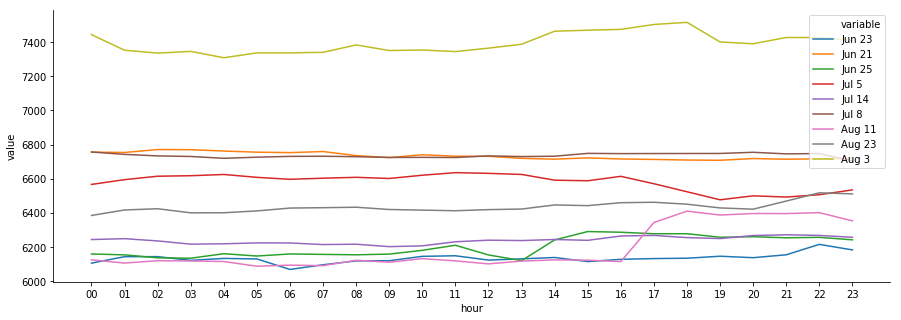

In [14]:
plt.figure(figsize=(15,5))
sns.lineplot(x="hour", y="value", hue="variable", data = melted_daily)
sns.despine()

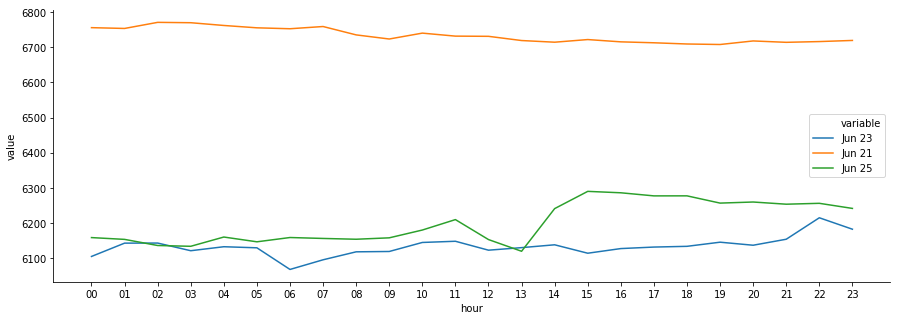

In [15]:
june = melted_daily[melted_daily.variable.str.contains("Jun")]
plt.figure(figsize=(15,5))
sns.lineplot(x="hour", y="value", hue="variable", data = june)
sns.despine()

In [16]:
# number of days in may
len(bitcoin[(bitcoin.index.month == 6)].index.day.unique())

17

In [17]:
# number of days in june
len(bitcoin[(bitcoin.index.month == 7)].index.day.unique())

31

In [18]:
# number of days in july
len(bitcoin["2018-08"].index.day.unique())

22

### Stationary 

Due to missing timestamps, it is hard to make the data stationary

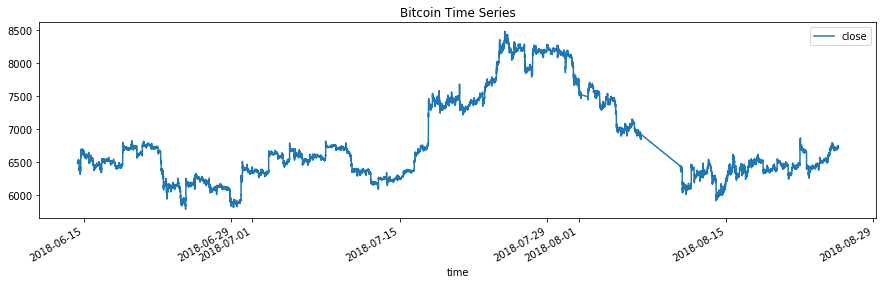

In [19]:
# overall trend
bitcoin.plot(figsize=(15,4))
plt.title('Bitcoin Time Series')
plt.show()

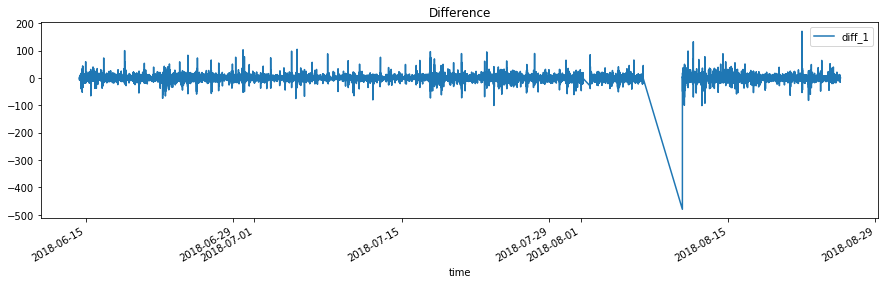

In [20]:
bitcoin['diff_1'] = bitcoin.close - bitcoin.close.shift()
bitcoin = bitcoin.fillna(method="ffill").dropna()
bitcoin.plot(y='diff_1', figsize=(15,4))
plt.title('Difference')
plt.show()

In [21]:
# large difference where?
bitcoin[bitcoin.diff_1 < -400].index

DatetimeIndex(['2018-08-10 16:20:00'], dtype='datetime64[ns]', name='time', freq=None)

In [22]:
bitcoin.loc['2018-08-10 16:20:00']

close     6433.430176
diff_1    -480.339844
Name: 2018-08-10 16:20:00, dtype: float64

In [23]:
# see the data for August 10
bitcoin.loc["2018-08-10"].head()

,close,diff_1
time,,
2018-08-10 16:20:00,6433.430176,-480.339844
2018-08-10 16:21:00,6425.060059,-8.370117
2018-08-10 16:22:00,6422.390137,-2.669922
2018-08-10 16:23:00,6423.459961,1.069824
2018-08-10 16:24:00,6425.060059,1.600098


In [24]:
# what is before:  august 09, 08, 07 are missing. August 6 is the previous value
bitcoin.loc["2018-08-06"].tail(1)

,close,diff_1
time,,
2018-08-06 23:06:00,6913.77002,-2.45996


In [25]:
# The data is sequential but it contains discountinuity
for month_idx in [6,7,8]:
    mini = bitcoin.loc[f"2018-{month_idx}"].index.min()
    maxi = bitcoin.loc[f"2018-{month_idx}"].index.max()
    print(f"{calendar.month_abbr[month_idx]}: minimum: {mini}, maximum: {maxi}")

Jun: minimum: 2018-06-14 09:32:00, maximum: 2018-06-30 23:59:00
Jul: minimum: 2018-07-01 00:00:00, maximum: 2018-07-31 23:59:00
Aug: minimum: 2018-08-01 00:00:00, maximum: 2018-08-25 16:40:00


### Modeling: ARIMA

Partial auto correlation helps in the selection lag paramter for AR

Text(0.5, 1.0, 'PACF- bitcoin closing price')

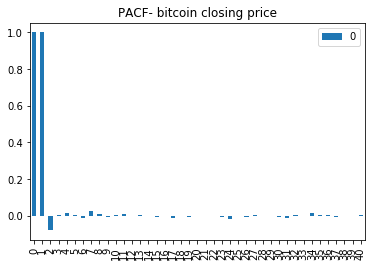

In [26]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(bitcoin.close))
x_acf.plot(kind='bar')
plt.title("PACF- bitcoin closing price")

Text(0.5, 1.0, 'PACF- bitcoin AR')

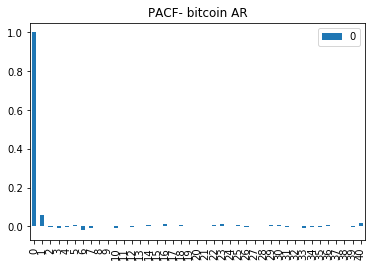

In [27]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(bitcoin.diff_1))
x_acf.plot(kind='bar')
plt.title("PACF- bitcoin AR")

In [28]:
# I model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: Futu

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                97722
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -308507.532
Method:                           css   S.D. of innovations              5.686
Date:                Thu, 14 Mar 2019   AIC                         617019.064
Time:                        02:35:00   BIC                         617038.044
Sample:                             1   HQIC                        617024.830
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.018      0.128      0.898      -0.033       0.038
Residuals Description
count    9.772200e+04
mean     7.653009e-08
std      5.686291e+00
min     -4.803422e+02
25%     -2.225442e-01

In [29]:
# AR model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                97723
Model:                     ARMA(1, 0)   Log Likelihood             -308513.972
Method:                       css-mle   S.D. of innovations              5.686
Date:                Thu, 14 Mar 2019   AIC                         617033.944
Time:                        02:35:01   BIC                         617062.414
Sample:                             0   HQIC                        617042.593
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6773.5261    324.691     20.861      0.000    6137.142    7409.910
ar.L1.close     1.0000   2.62e-05   3.82e+04      0.000       1.000       1.000
                                    Roots       

In [30]:
# ARMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                97723
Model:                     ARMA(1, 1)   Log Likelihood             -308337.975
Method:                       css-mle   S.D. of innovations              5.676
Date:                Thu, 14 Mar 2019   AIC                         616683.951
Time:                        02:36:56   BIC                         616721.910
Sample:                             0   HQIC                        616695.482
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6773.5230    316.801     21.381      0.000    6152.605    7394.441
ar.L1.close     0.9999   2.78e-05   3.59e+04      0.000       1.000       1.000
ma.L1.close     0.0599      0.003     18.822    

In [31]:
# ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin.close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                97722
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -308331.467
Method:                       css-mle   S.D. of innovations              5.676
Date:                Thu, 14 Mar 2019   AIC                         616670.933
Time:                        02:39:00   BIC                         616708.893
Sample:                             1   HQIC                        616682.465
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.019      0.120      0.904      -0.035       0.040
ar.L1.D.close     0.0277      0.046      0.601      0.548      -0.063       0.118
ma.L1.D.close     0.0323      0.046     

Text(0.5, 1.0, 'Histogram of Residuals')

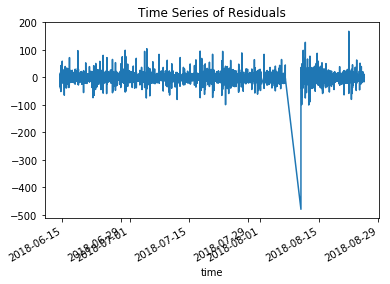

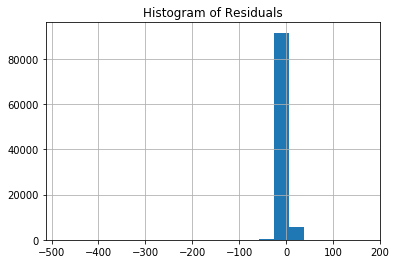

In [32]:
# check residuals
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

## June and July

June and July data is relatively cleaner. Let me try to train/test ARIMA model

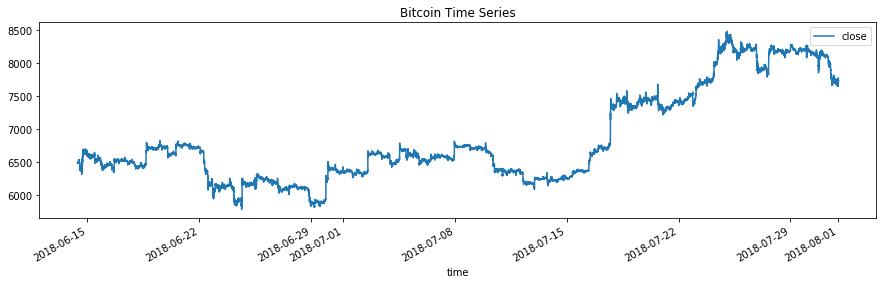

In [33]:
bitcoin_junejuly = bitcoin[bitcoin.index.month.isin([6,7])].drop("diff_1", axis=1).copy()
# junejuly trend,seasonality
bitcoin_junejuly.plot(figsize=(15,4))
plt.title('Bitcoin Time Series')
plt.show()

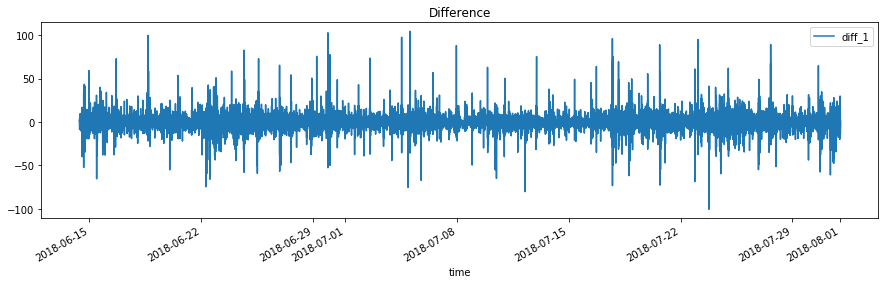

In [34]:
bitcoin_junejuly['diff_1'] = bitcoin_junejuly.close - bitcoin_junejuly.close.shift()
bitcoin_junejuly = bitcoin_junejuly.fillna(method="ffill").dropna()
bitcoin_junejuly.plot(y='diff_1', figsize=(15,4))
plt.title('Difference')
plt.show()

Text(0.5, 1.0, 'Bitcoin')

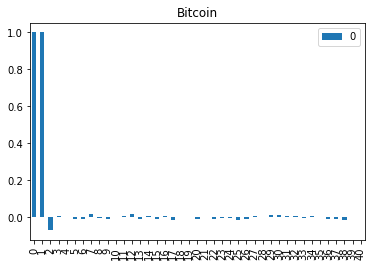

In [35]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(bitcoin_junejuly.close))
x_acf.plot(kind='bar')
plt.title("Bitcoin")

In [36]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin_junejuly.close, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                68444
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -210088.638
Method:                           css   S.D. of innovations              5.210
Date:                Thu, 14 Mar 2019   AIC                         420181.276
Time:                        02:39:04   BIC                         420199.544
Sample:                             1   HQIC                        420186.916
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.020      0.916      0.360      -0.021       0.057
Residuals Description
count    6.844400e+04
mean     1.124131e-13
std      5.209926e+00
min     -1.007087e+02
25%     -7.828984e-02

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [37]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bitcoin_junejuly.close, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                68443
Model:                 ARIMA(1, 2, 1)   Log Likelihood             -209953.108
Method:                       css-mle   S.D. of innovations              5.200
Date:                Thu, 14 Mar 2019   AIC                         419914.217
Time:                        02:40:43   BIC                         419950.752
Sample:                             2   HQIC                        419925.496
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.369e-06   9.79e-06     -0.242      0.809   -2.15e-05    1.68e-05
ar.L1.D2.close     0.0642      0.004     16.803      0.000       0.057       0.072
ma.L1.D2.close    -0.9996      0.000

In [38]:
len(bitcoin_junejuly)

68445

### Train Test Split

In [39]:
bitcoin_junejuly = bitcoin_junejuly[['close']]

In [41]:
split_point = int(len(bitcoin_junejuly)*0.80)
split_point

54756

In [42]:
train = bitcoin_junejuly.iloc[0:split_point]
test = bitcoin_junejuly.iloc[split_point:]

In [45]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                54755
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -165550.922
Method:                       css-mle   S.D. of innovations              4.976
Date:                Thu, 14 Mar 2019   AIC                         331109.845
Time:                        02:45:53   BIC                         331145.487
Sample:                             1   HQIC                        331120.963
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0179      0.023      0.783      0.434      -0.027       0.063
ar.L1.D.close     0.1954      0.061      3.197      0.001       0.076       0.315
ma.L1.D.close    -0.1325      0.062     

Text(0.5, 1.0, 'Histogram of Residuals')

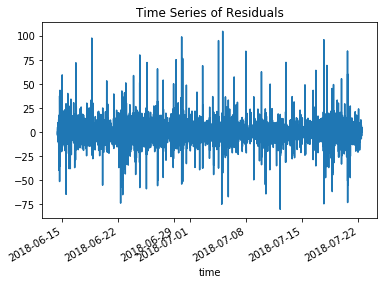

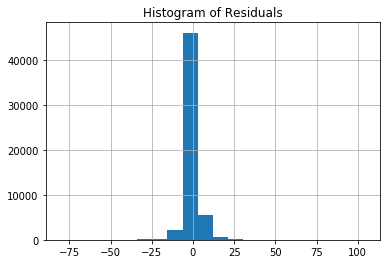

In [46]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

In [47]:
len(test)

13689

the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information

In [49]:
predictions = model_fit.forecast(steps=len(test))[0]

In [51]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test.close, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 256359.286


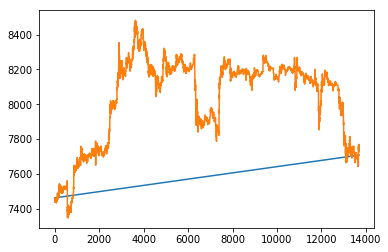

In [59]:
sns.lineplot(data = predictions)
sns.lineplot(data = test.close.values)

In [61]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(2,2,2))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                54754
Model:                 ARIMA(2, 2, 2)   Log Likelihood             -165555.820
Method:                       css-mle   S.D. of innovations              4.976
Date:                Thu, 14 Mar 2019   AIC                         331123.639
Time:                        03:11:35   BIC                         331177.103
Sample:                             2   HQIC                        331140.316
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.019e-06    6.5e-06      0.157      0.875   -1.17e-05    1.38e-05
ar.L1.D2.close    -0.7241      0.035    -20.851      0.000      -0.792      -0.656
ar.L2.D2.close     0.0547      0.005

Test MSE: 100130.092
RMSE:  316.4333921384545


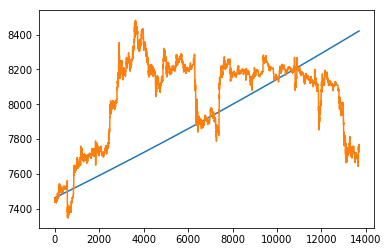

In [64]:
predictions = model_fit.forecast(steps=len(test))[0]
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test.close, predictions)
print('Test MSE: %.3f' % error)
print('RMSE: ', np.sqrt(error))
sns.lineplot(data = predictions)
sns.lineplot(data = test.close.values)

In [63]:
test.close.describe()

count    13689.000000
mean      8038.255217
std        242.577869
min       7347.000000
25%       7886.000000
50%       8152.100098
75%       8204.129883
max       8482.799805
Name: close, dtype: float64

In [66]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(3,2,3))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Tinsae\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Tinsae\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: Ru

                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                54754
Model:                 ARIMA(3, 2, 3)   Log Likelihood             -165549.910
Method:                       css-mle   S.D. of innovations              4.975
Date:                Thu, 14 Mar 2019   AIC                         331115.820
Time:                        03:51:49   BIC                         331187.105
Sample:                             2   HQIC                        331138.056
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.173e-07   8.95e-06      0.091      0.927   -1.67e-05    1.84e-05
ar.L1.D2.close    -1.0589        nan        nan        nan         nan         nan
ar.L2.D2.close    -0.7216        nan

Test MSE: 105860.462
RMSE:  325.362048169755


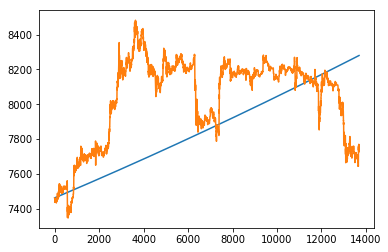

In [67]:
predictions = model_fit.forecast(steps=len(test))[0]
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test.close, predictions)
print('Test MSE: %.3f' % error)
print('RMSE: ', np.sqrt(error))
sns.lineplot(data = predictions)
sns.lineplot(data = test.close.values)

References

https://www.youtube.com/watch?v=D9y6dcy0xK8